In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

Test data is set aside. It will not be touched until the final model has been confirmed.


We will focus on the train_data.

In [3]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As we have known, 'Survived' is the label.

Age, Fare, Sibsp and Parch are numerical variables. Age contains missing values, and it will be handled later.

Pclass, Sex, Embarked are categorical variables. The titles mentioned in "Name" can be also categorized into groups.

Ticket and Cabin are string variables, which will not be considered in the model. Cabin could have provided some information to modelling, if the variable did not have too many missing values. 

To summarize, the features that I will play around are: Age, Fare, Sibsp, Parch, Pclass, Sex, Embarked, Title(Name).



In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's visualize stacked histograms with different colours representing 1='Survived' and 0='Not Survivied'.

In [6]:
#import seaborn as sns

#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
#ax_id = [axes[0,0],axes[0,1],axes[0,2],axes[1,0], axes[1,1]]
#for i in range(len(data_temp.columns)):
#    ax = sns.distplot(surv.iloc[:,i], bins=20, label='Survived', kde=False, ax=ax_id[i])
#    ax = sns.distplot(nonsurv.iloc[:,i], bins=20, label='NotSurvived', kde=False, ax=ax_id[i])
#    ax.legend()
    
#fig.delaxes(axes[1,2])


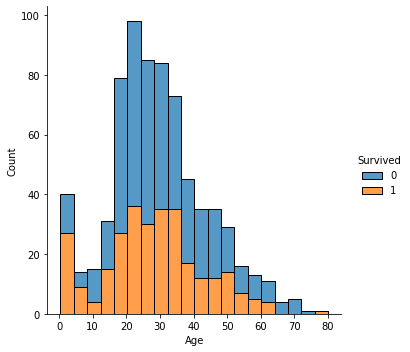

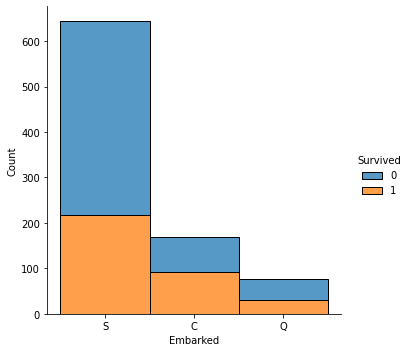

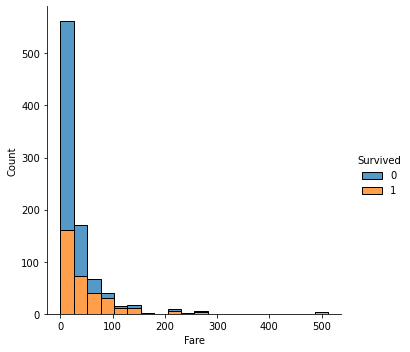

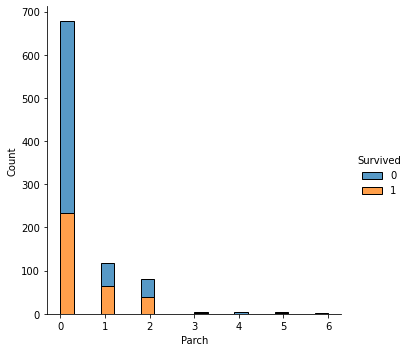

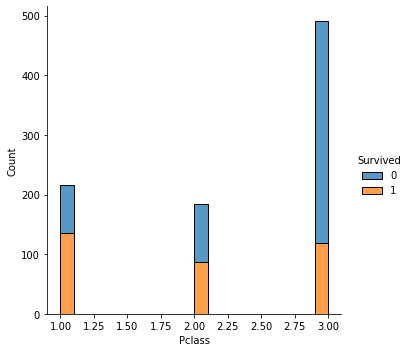

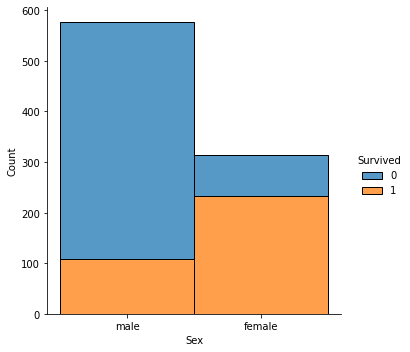

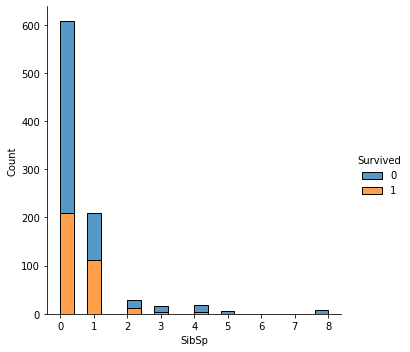

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

data_temp = train_data[train_data.columns.difference(['PassengerId','Survived','Cabin','Name','Ticket'])]
for i in range(len(data_temp.columns)):
    sns.displot(train_data, x=data_temp.columns[i], hue="Survived", multiple="stack", bins=20)
    plt.show()

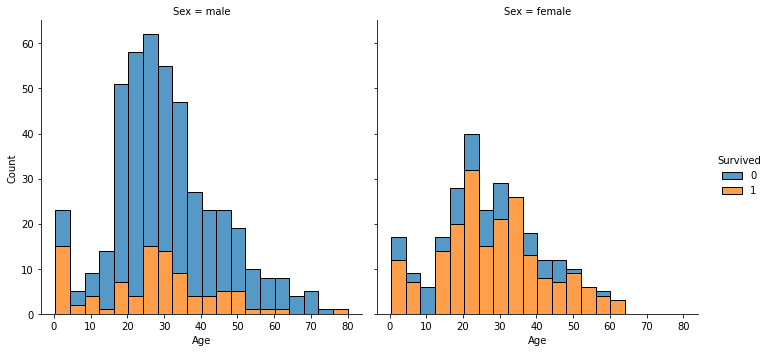

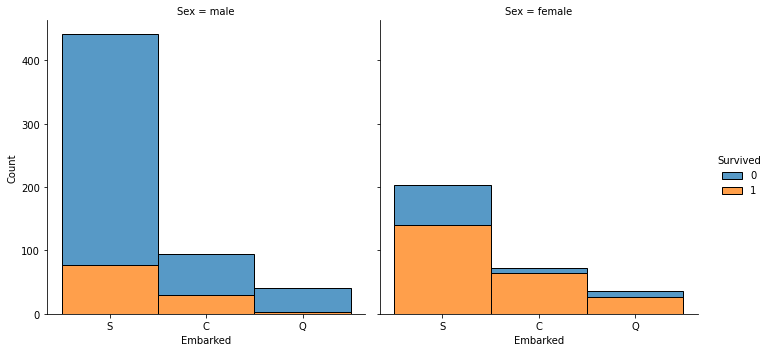

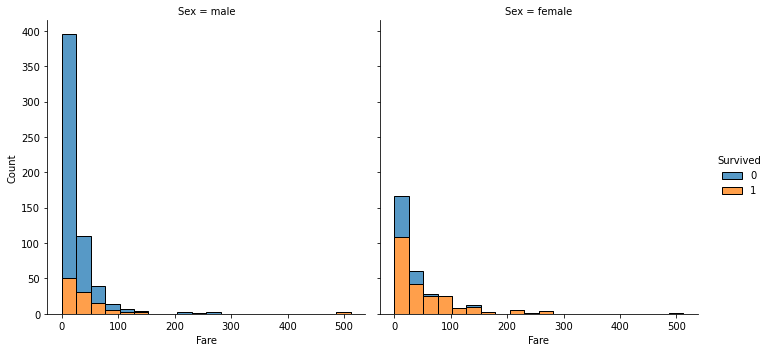

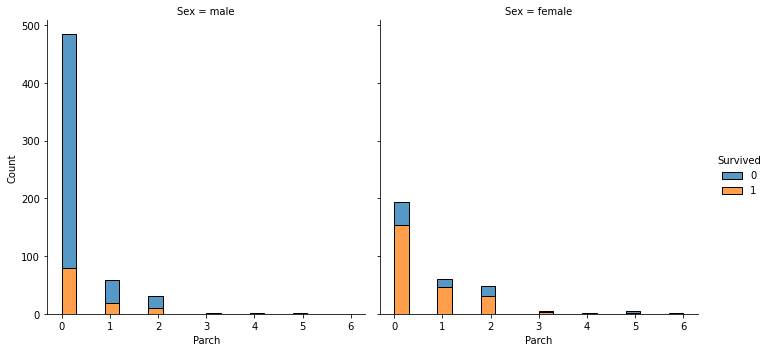

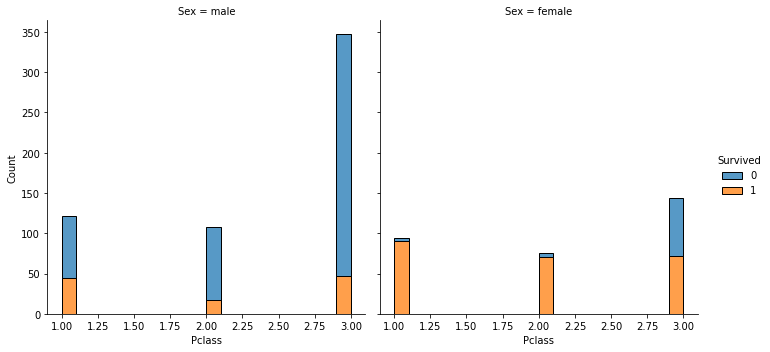

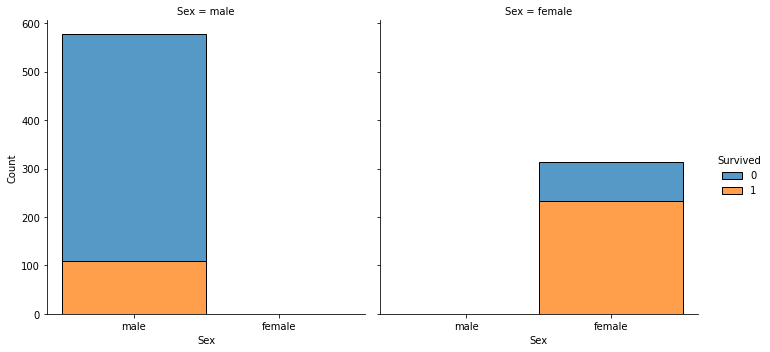

In [8]:
for i in range(len(data_temp[data_temp.columns.difference(['Sex'])].columns)):
    sns.displot(train_data, x=data_temp.columns[i], hue="Survived", multiple="stack", bins=20, col="Sex")
    plt.show()

In [9]:
# Start Data Preprocessing
## Categorize individuals into Titles
import re
def title_group(names):
    titles = pd.Series([re.search(', (.+?)\. ', name).group(1) for name in names])
    # fixing typoes
    titles = titles.replace('Mlle', 'Miss')
    titles = titles.replace('Ms', 'Miss')
    titles = titles.replace('Mme', 'Mrs')
    # create a new category for rare titles
    titles = titles.replace(['Dr','Rev','Major','Col','the Countess', 'Capt', 'Sir','Lady', 'Don', 'Jonkheer', 'Dona'], 'rare')
    return titles    
#pd.Series(titles).value_counts()

In [10]:
train_data["Title"] = title_group(train_data.Name)
test_data["Title"] = title_group(test_data.Name)

<AxesSubplot:xlabel='Title', ylabel='count'>

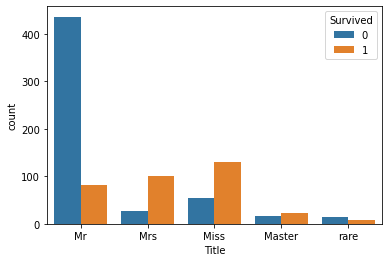

In [11]:
## Visualize title in a histogram
#sns.displot(train_data, x='Title', hue="Survived", multiple="stack", bins=20)
sns.countplot(x='Title', hue='Survived', data=train_data)

In [12]:
# Create Number of travel partners denoted as "Partners"
train_data["Partners"] = train_data.Parch + train_data.SibSp
train_data["Partners"].value_counts()

test_data["Partners"] = test_data.Parch + test_data.SibSp

<AxesSubplot:xlabel='Partners', ylabel='count'>

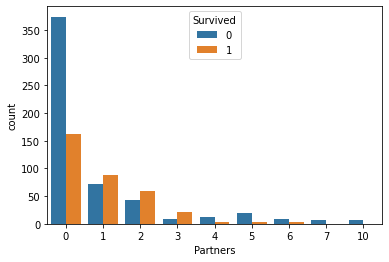

In [13]:
## Visualize "Partners" in a histogram
sns.countplot(x='Partners', hue='Survived', data=train_data)

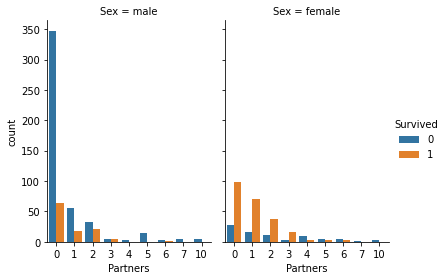

In [14]:
sns.catplot(x="Partners", hue="Survived", col="Sex",data=train_data, kind="count",
                height=4, aspect=.7);

In [15]:
## grouping 
### group 0, 1-3, 4-6, >=7
def num_partners_grouping(numbers):
    cat = []
    for number in numbers:
        if number==0:
            temp = 1
        elif number<=3:
            temp = 2
        elif number<=6:
            temp = 3
        else:
            temp = 4
        cat.append(temp)
    return cat

In [16]:
#[partners_grouping(number) for number in train_data.Partners]
train_data["Partners_cat"] = num_partners_grouping(train_data.Partners)
test_data["Partners_cat"] = num_partners_grouping(test_data.Partners)

<AxesSubplot:xlabel='Partners_cat', ylabel='count'>

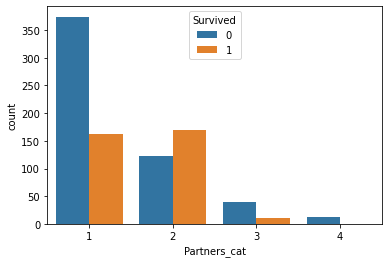

In [17]:
## Visualize again
sns.countplot(x='Partners_cat', hue='Survived', data=train_data)

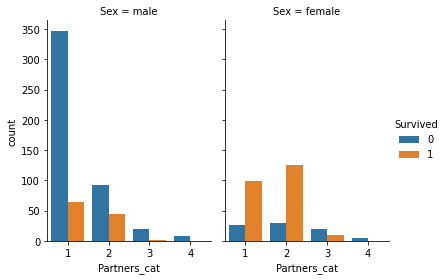

In [18]:
sns.catplot(x="Partners_cat", hue="Survived", col="Sex",data=train_data, kind="count",
                height=4, aspect=.7);

In [19]:
## Replace missing value in Age with medium
age_median = train_data.Age.median()
train_data.Age.fillna(age_median, inplace=True)
#pd.Series(train_data["Age"]).value_counts()

test_data.Age.fillna(age_median, inplace=True)

In [20]:
## Grouping Age
def age_grouping(ages):
    cat = []
    for age in ages:
        if age<8:
            temp=1
        elif age<=16:
            temp=2
        elif age<=35:
            temp=3
        elif age<=52:
            temp=4
        elif age<=63:
            temp=5
        elif age<=77:
            temp=6
        else:
            temp=7
        cat.append(temp)
    return cat

In [21]:
train_data["Age_cat"] = age_grouping(train_data.Age)
train_data["Age_cat"].value_counts()

test_data["Age_cat"] = age_grouping(test_data.Age)

In [22]:
# drop assumed unnecessarily features
train_features = train_data.drop(["PassengerId", "Name", "Ticket", "Cabin", "Partners",'Age'],
                             axis=1)
test_features = test_data.drop(["PassengerId", "Name", "Ticket", "Cabin", "Partners",'Age'],
                             axis=1)


# Separate labels from features
train_labels = train_features["Survived"]
train_features = train_features.drop(["Survived"], axis=1)

# split features into numerical and categorical feautures
feature_list = list(train_features)
ord_cat = ["Partners_cat", "Age_cat"] #ordinal categorical variables
nom_cat = ["Sex", "Embarked", "Title", "Pclass"] #nominal categorical variables
train_features_nom_cat = train_features[nom_cat]
train_features_ord_cat = train_features[ord_cat]
train_features_num = train_features.drop(np.concatenate([ord_cat, nom_cat]), axis = 1)
num = list(train_features_num)

test_features_nom_cat = test_features[nom_cat]
test_features_ord_cat = test_features[ord_cat]
test_features_num = test_features.drop(np.concatenate([ord_cat, nom_cat]), axis = 1)


# Cleaning and scaling numerical features
# Transformation Pipelines
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_features_num = std_scaler.fit_transform(train_features_num)
test_features_num = std_scaler.transform(test_features_num)


In [23]:
# Cleaning and One-hot encoding categorical features for nominal features
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

mode_imputer = SimpleImputer(missing_values=np.nan,
                        strategy='most_frequent')
onehot_encoder = OneHotEncoder()
cat_pipeline = Pipeline([
    ("mode_imputer", mode_imputer),
    ("onehot_encoder", onehot_encoder)
])

train_features_nom_cat = cat_pipeline.fit_transform(train_features_nom_cat) # returns a sparse matrix
train_features_nom_cat = train_features_nom_cat.toarray()

test_features_nom_cat = cat_pipeline.fit_transform(test_features_nom_cat) # returns a sparse matrix
test_features_nom_cat = test_features_nom_cat.toarray()


In [24]:
train_features_prepared = np.append(train_features_num, train_features_nom_cat, axis=1)
train_features_prepared = np.append(train_features_prepared, train_features_ord_cat, axis=1)

test_features_prepared = np.append(test_features_num, test_features_nom_cat, axis=1)
test_features_prepared = np.append(test_features_prepared, test_features_ord_cat, axis=1)

In [25]:
col_names = num + list(np.concatenate(onehot_encoder.categories_)) + ord_cat
for i in range(len(col_names)):
    if ~isinstance(col_names[i], str):
        col_names[i] = str(col_names[i])

train_features_prepared = pd.DataFrame(train_features_prepared, 
                                       columns = col_names)
train_features_prepared.columns

Index(['SibSp', 'Parch', 'Fare', 'female', 'male', 'C', 'Q', 'S', 'Master',
       'Miss', 'Mr', 'Mrs', 'rare', '1', '2', '3', 'Partners_cat', 'Age_cat'],
      dtype='object')

In [26]:
test_features_prepared = pd.DataFrame(test_features_prepared, 
                                       columns = col_names)
test_features_prepared.columns

Index(['SibSp', 'Parch', 'Fare', 'female', 'male', 'C', 'Q', 'S', 'Master',
       'Miss', 'Mr', 'Mrs', 'rare', '1', '2', '3', 'Partners_cat', 'Age_cat'],
      dtype='object')

In [27]:
# Create feature cross: Sex*Age_cat, Sex*Partners_cat
train_features_prepared["male_age"] = train_features_prepared["male"] * train_features_prepared["Age_cat"]
train_features_prepared["female_age"] = train_features_prepared["female"] * train_features_prepared["Age_cat"]
train_features_prepared["male_partners"] = train_features_prepared["male"] * train_features_prepared["Partners_cat"]
train_features_prepared["female_partners"] = train_features_prepared["female"] * train_features_prepared["Partners_cat"]

I will do the feature crossing on test data before knowing feature importance.

In [28]:
train_features_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SibSp            891 non-null    float64
 1   Parch            891 non-null    float64
 2   Fare             891 non-null    float64
 3   female           891 non-null    float64
 4   male             891 non-null    float64
 5   C                891 non-null    float64
 6   Q                891 non-null    float64
 7   S                891 non-null    float64
 8   Master           891 non-null    float64
 9   Miss             891 non-null    float64
 10  Mr               891 non-null    float64
 11  Mrs              891 non-null    float64
 12  rare             891 non-null    float64
 13  1                891 non-null    float64
 14  2                891 non-null    float64
 15  3                891 non-null    float64
 16  Partners_cat     891 non-null    float64
 17  Age_cat         

In [29]:
# train and validation sets
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(train_features_prepared, train_labels, random_state=42)

In [30]:
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Random Forests
param_grid = [
    {
    'max_depth':[4,6,8,10,12],
    }
]
rnd_clf = RandomForestClassifier(bootstrap=True, n_estimators=500, 
                                 n_jobs=-1, oob_score=True)

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='accuracy',
                          return_train_score=True, refit=True)
grid_search.fit(train_features_prepared, train_labels)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                              oob_score=True),
             param_grid=[{'max_depth': [4, 6, 8, 10, 12]}],
             return_train_score=True, scoring='accuracy')

In [31]:
grid_search.best_score_

0.8316427091833531

In [32]:
rnd_clf_best = grid_search.best_estimator_
rnd_clf_best

RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

In [33]:
rnd_clf_best.oob_score_

0.8316498316498316

In [34]:
# Double checking cv scores
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rnd_clf_best, train_features_prepared, train_labels, scoring="accuracy",
                        cv=10)

print("Scores:", scores)
print("Mean:", scores.mean())
print("Std_dev:", scores.std())

Scores: [0.82222222 0.85393258 0.7752809  0.87640449 0.84269663 0.79775281
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8305368289637952
Std_dev: 0.03419284897313234


In [35]:
# Checking Feature Importance
feature_imp = pd.DataFrame()
feature_imp['Variable'] = train_features_prepared.columns
feature_imp["Imp"] = rnd_clf_best.feature_importances_
feature_imp.sort_values(by='Imp', ascending=False)

,Variable,Imp
18,male_age,0.142772
21,female_partners,0.111392
10,Mr,0.103545
19,female_age,0.090527
20,male_partners,0.085775
3,female,0.082488
4,male,0.071455
15,3,0.062003
2,Fare,0.057353
13,1,0.038793


I will drop "S", "C", "Q", "Parch", and retrain the model again


In [36]:
train_features_prepared_dropped = train_features_prepared.drop(['S', "C", "Q", "Parch"], axis=1)

In [37]:

# Retrain the model using same arguments of rnd_clf_best

rnd_clf_dropped = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

rnd_clf_dropped.fit(train_features_prepared_dropped, train_labels)


RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

In [38]:
rnd_clf_dropped.oob_score_

0.835016835016835

In [39]:
# Double checking cv scores
scores_dropped = cross_val_score(rnd_clf_dropped, train_features_prepared_dropped, train_labels, scoring="accuracy",
                        cv=10)

print("Scores:", scores_dropped)
print("Mean:", scores_dropped.mean())
print("Std_dev:", scores_dropped.std())

Scores: [0.82222222 0.87640449 0.7752809  0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8339076154806492
Std_dev: 0.035389116536277826


In [40]:
# Checking Feature Importance
feature_imp = pd.DataFrame()
feature_imp['Variable'] = train_features_prepared_dropped.columns
feature_imp["Imp"] = rnd_clf_dropped.feature_importances_
feature_imp.sort_values(by='Imp', ascending=False)

,Variable,Imp
14,male_age,0.157677
6,Mr,0.111133
17,female_partners,0.106986
3,male,0.088170
15,female_age,0.079609
11,3,0.074887
16,male_partners,0.074741
2,female,0.071585
1,Fare,0.058580
12,Partners_cat,0.043747


The feature removal improves the estimate of generization accuracy.


I will remove "Age_cat" to retrain the model again to see if there is improvement.

In [41]:
# Drop 'Age_cat
train_features_prepared_dropped1 = train_features_prepared_dropped.drop(['Age_cat'], axis=1)


# Retrain the model using same arguments of rnd_clf_best

rnd_clf_dropped1 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

rnd_clf_dropped1.fit(train_features_prepared_dropped1, train_labels)


RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

In [42]:
rnd_clf_dropped1.oob_score_

0.835016835016835

In [43]:
# Double checking cv scores
scores_dropped = cross_val_score(rnd_clf_dropped1, train_features_prepared_dropped1, train_labels, scoring="accuracy",
                        cv=10)

print("Scores:", scores_dropped)
print("Mean:", scores_dropped.mean())
print("Std_dev:", scores_dropped.std())

Scores: [0.83333333 0.87640449 0.7752809  0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8350187265917602
Std_dev: 0.0351785892234905


In [44]:
# Checking Feature Importance
feature_imp = pd.DataFrame()
feature_imp['Variable'] = train_features_prepared_dropped1.columns
feature_imp["Imp"] = rnd_clf_dropped1.feature_importances_
feature_imp.sort_values(by='Imp', ascending=False)

,Variable,Imp
13,male_age,0.176647
6,Mr,0.111600
14,female_age,0.090521
16,female_partners,0.086737
3,male,0.083951
15,male_partners,0.083066
11,3,0.072063
1,Fare,0.065736
2,female,0.065041
12,Partners_cat,0.046912


In [45]:
train_features_prepared = train_features_prepared_dropped1

**Retrain the final model**

In [46]:

rnd_clf_final = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

rnd_clf_final.fit(train_features_prepared, train_labels)

RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

In [47]:
from sklearn.metrics import accuracy_score

y_pred_train = rnd_clf_final.predict(train_features_prepared)
accuracy_score(train_labels, y_pred_train)

0.835016835016835

**Predict test_features_prepared**

In [48]:
test_features_prepared["male_age"] = test_features_prepared["male"] * test_features_prepared["Age_cat"]
test_features_prepared["female_age"] = test_features_prepared["female"] * test_features_prepared["Age_cat"]
test_features_prepared["male_partners"] = test_features_prepared["male"] * test_features_prepared["Partners_cat"]
test_features_prepared["female_partners"] = test_features_prepared["female"] * test_features_prepared["Partners_cat"]

test_features_prepared = test_features_prepared.drop(['S', "C", "Q", "Parch", 'Age_cat'], axis=1)

In [49]:
test_features_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SibSp            418 non-null    float64
 1   Fare             417 non-null    float64
 2   female           418 non-null    float64
 3   male             418 non-null    float64
 4   Master           418 non-null    float64
 5   Miss             418 non-null    float64
 6   Mr               418 non-null    float64
 7   Mrs              418 non-null    float64
 8   rare             418 non-null    float64
 9   1                418 non-null    float64
 10  2                418 non-null    float64
 11  3                418 non-null    float64
 12  Partners_cat     418 non-null    float64
 13  male_age         418 non-null    float64
 14  female_age       418 non-null    float64
 15  male_partners    418 non-null    float64
 16  female_partners  418 non-null    float64
dtypes: float64(17)
m

There is a missing value in Fare.

In [50]:
median = train_features_prepared.Fare.median()
test_features_prepared["Fare"] = test_features_prepared["Fare"].fillna(median)
test_features_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SibSp            418 non-null    float64
 1   Fare             418 non-null    float64
 2   female           418 non-null    float64
 3   male             418 non-null    float64
 4   Master           418 non-null    float64
 5   Miss             418 non-null    float64
 6   Mr               418 non-null    float64
 7   Mrs              418 non-null    float64
 8   rare             418 non-null    float64
 9   1                418 non-null    float64
 10  2                418 non-null    float64
 11  3                418 non-null    float64
 12  Partners_cat     418 non-null    float64
 13  male_age         418 non-null    float64
 14  female_age       418 non-null    float64
 15  male_partners    418 non-null    float64
 16  female_partners  418 non-null    float64
dtypes: float64(17)
m

In [51]:
y_pred = rnd_clf_final.predict(test_features_prepared)

In [52]:
y_pred = pd.DataFrame({'PassengerId':test_data.PassengerId, 'Survived':y_pred})
y_pred

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [53]:
y_pred.to_csv('y_pred.csv', index=False)